## Exercise 9: Policy gradient with Reinforce

In this exercise, we solve a continuous actions version of cart pole using Reinforce.

In `exercise06` we looked at DQN, where we used function approximation to learn on continuous state spaces. To additionaly extend the action space to a continuous action spaces, one typically uses policy gradient methods.

#### Parameterized Policies

For this we need a parameterized policy $\pi_\theta$ that gets as an input a state $x$ and returns a distribution of possible actions $\pi_\theta( \cdot | x)$.

Similar to the previous exercise we also use a neural network for this. The following implementation uses a neural network to  predict the mean $\mu$ of a gaussian, whereas $\sigma$, the standard deviation, is fixed.

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Normal


class Policy(nn.Module):
    def __init__(self,
                 env,
                 sigma=0.1):
        super(Policy, self).__init__()
        self.env = env
        self.set_sigma(sigma)
    
        self.features = nn.Linear(np.prod(env.observation_space.shape),
                                  np.prod(env.action_space.shape),
                                  bias=False)

    def set_sigma(self, sigma):
        self.sigma = torch.full(self.env.action_space.shape, sigma)
        
    def forward(self, x, action=None):
        x = torch.as_tensor(x).float().flatten()
        x = self.features(x).reshape(self.sigma.shape)
        
        distr = Normal(x, self.sigma)  # The output of the features are used as the mean.

        if action is not None:
            return distr.log_prob(action)  # The log of the probabiliy density function.

        action = distr.sample()

        # We clip the action to ensure that they are in bound.
        return action.clip(self.env.action_space.low.item(),
                           self.env.action_space.high.item())

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Sampling an action**:

Using the policy we can now sample an action:

Text(0.5, 1.0, 'Action Distribution')

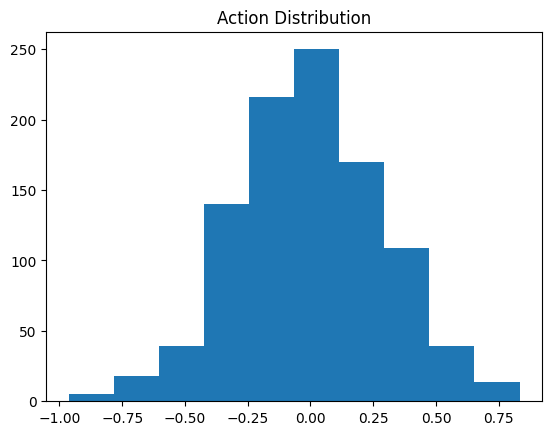

In [3]:
import cont_cartpole
import gymnasium as gym
import matplotlib.pyplot as plt


env = gym.make("ContCartPole-v0")
agent = Policy(env, sigma=0.3)

state, _ = env.reset()
actions = [agent(state).item() for _ in range(1000)]

plt.hist(actions)
plt.title("Action Distribution")

Depending on $\sigma$ the noisiness of the policy increases. Similar to the $\epsilon$-greedy policy of `exercise05` and `exercise06`, this is needed to explore new actions.

### 2 Reinforce

Now, we want to implement Reinforce. To understand what you need to do, please look back at the slides of the last lecture.

In [4]:
from collections import namedtuple
from tqdm import trange

EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


def rollout(agent, env, render=False, sigma=0.):
    """ Collects states, rewards and actions of one episode."""

    rewards = []
    actions = []
    states = []

    state, _ = env.reset()

    while True:
        state = torch.tensor(state).float()
        states.append(state)

        with torch.no_grad():
            action = agent(state)

        state, reward, truncated, terminated, _ = env.step(action)

        rewards.append(reward)
        actions.append(action)

        if truncated or terminated:
            break

    return states, torch.tensor(rewards).float(), actions


def reinforce(agent, env, num_episodes=1000, gamma=0.99, lr=0.0001, stop_at=1000):
    """ A short implementation of reinforce."""
    optimizer = torch.optim.SGD(agent.parameters(), lr=lr)

    episode_rewards = []
    episode_lengths = []

    episode_range = trange(num_episodes)
    for episode in episode_range:
        states, rewards, actions = rollout(agent, env)
        num_steps = len(rewards)

        for t, (state, action) in enumerate(zip(states, actions)):
            state = torch.as_tensor(state).to(torch.float)
            
            # TODO 1: Calculate the disc return of the episode
            # Tipp: torch.inner and torch.arange are nice functions for this :)
            disc_return = torch.inner(gamma ** torch.arange(0, num_steps - t), rewards[t: num_steps])
            
            # TODO 2: Calculate the policy_objective.
            policy_objective = gamma**t * disc_return * agent(state, action)

            optimizer.zero_grad()
            (-policy_objective.mean()).backward()  # We do gradient ASCENT not descent!
            optimizer.step()
        
        episode_rewards.append(sum(rewards))
        episode_lengths.append(num_steps)
        episode_range.set_description(f"Episode Reward {episode_rewards[-1].item():4} ")
        
        if num_steps >= stop_at:
            break
    
    return EpisodeStats(episode_lengths, episode_rewards)

Let's train :). To speed up training and because Reinforce is not a very stable algorithm, we stopped training when a certain value is achieved with `stop_at`. If your computer is fast enough, you can of course set a higher value there.

In [5]:
env = gym.make("ContCartPole-v0", render_mode="rgb_array")
agent = Policy(env, sigma=0.4)
stats = reinforce(agent, env, lr=0.001, num_episodes=1000, stop_at=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
Episode Reward 1000.0 :  20%|█▉        | 195/1000 [00:12<00:52, 15.40it/s]


#### 8.3.1 Visualization of continuous action cart-pole

**An example rollout**:

/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")


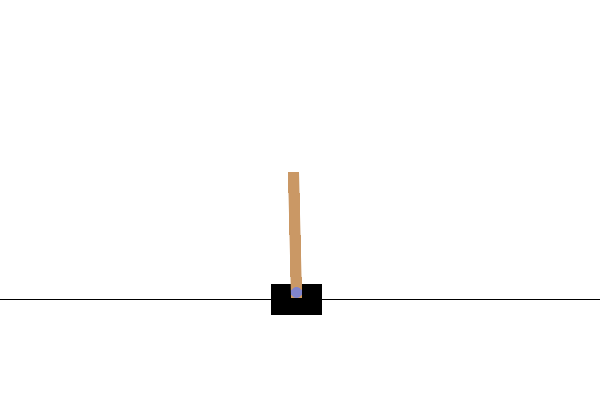

In [6]:
from visualization import save_rgb_animation
from IPython.display import Image as IImage

agent.set_sigma(0.000001)


def rendered_rollout(policy, env, max_steps=200):
    steps = 0
    
    state, _ = env.reset()
    imgs = [env.render()]

    while steps < max_steps:
        action = policy(state)
        state, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        steps += 1

        if terminated or truncated:
            break
    
    return imgs

imgs = rendered_rollout(agent, env)
save_rgb_animation(imgs, f"cartpole.gif", duration=40)
IImage(filename=f"cartpole.gif")

**Visualization of the episode stats:**

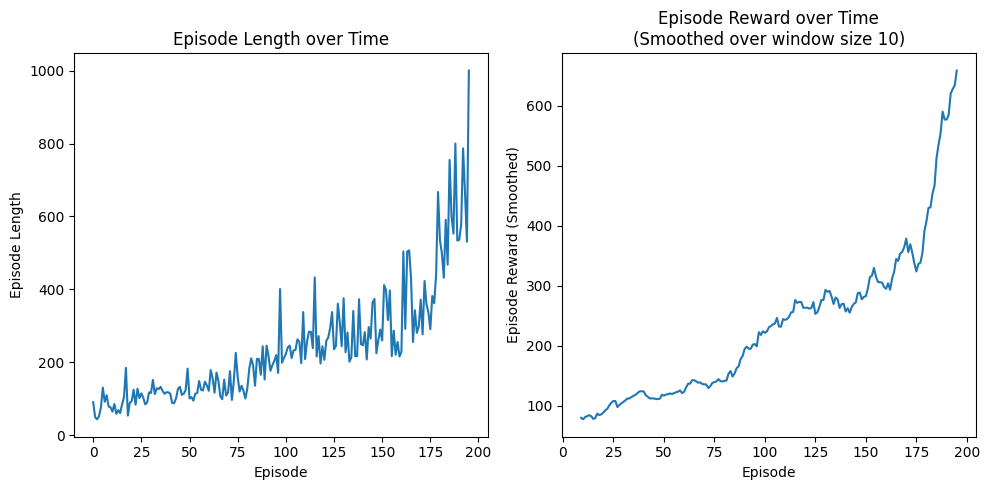

In [7]:
from visualization import plot_episode_stats

plot_episode_stats(stats)